# Ford GoBike System Data Exploration
## Data Overview
>This data set includes information about individual rides made in a bike-sharing system covering the `greater San Francisco Bay` area during **february 2019**.<br>

In [80]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('201902-fordgobike-tripdata.csv',parse_dates=['start_time','end_time'])

In [3]:
df.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


## Dataset Features
* Trip Duration in `seconds`
* Start Time and Date
* Stop Time and Date
* Start Station Name
* End Station Name
* Station ID
* Station Lat/Long
* Bike ID
* User Type: <br>
    `Customer` = 24-hour pass or 3-day pass user<br>
    `Subscriber` = Annual Member
* Gender:<br> 
    `male`<br>
    `female`
* Year of Birth

## Preliminary Wrangling
* **Dropping the NaN records.**
* **Correct all IDs types to objects.**

In [4]:
df.dropna(inplace=True)
df.start_station_id = df.start_station_id.astype(str)
df.end_station_id = df.end_station_id.astype(str)
df.bike_id = df.bike_id.astype(str)
df.member_birth_year = df.member_birth_year.astype(int)

### Helper Functions

In [5]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    m = m.astype(int)
    return m

In [6]:
def hour_style(x):
    if x >12:
        return f'{x-12} PM'
    elif x == 0:
        return f'{12} AM'
    elif x == 12:
        return f'{12} PM'
    else: 
        return f'{x} AM'

In [7]:
def Interquartile(df,col):
    ''' 
        This Function is used to detect and remove the outliers using the Interquartile Range rule.
        inputs: col -> name of the column.
        outputs: returns the filtered version of dataframe.
    '''
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df.query(f'(@Q1 - 1.5 * @IQR) <= {col} <= (@Q3 + 1.5 * @IQR)')

## Feature Engineering
Extract new features
* days: `Monday`, `Tuesday`, `Wednesday`, `Thursday`, `Friday`, `Saturday`, `Sunday`
* duration_min: trip duration in minutes.
* distance_meter: trip distance in meters.
* hour: hour at which trip started.

In [8]:
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

df['duration_min'] = df.duration_sec // 60 
df['distance_meter'] = haversine_np(df.start_station_longitude,df.start_station_latitude,\
                             df.end_station_longitude,df.end_station_latitude)
df['day'] = df['start_time'].dt.dayofweek
df.day = df.day.apply(lambda x:days[x])

df['hour'] = df['start_time'].dt.hour
df.hour = df.hour.apply(lambda x :hour_style(x))

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_sec,174952.0,704.002744,1642.204905,61.000000,323.000000,510.000000,789.000000,84548.000000
start_station_latitude,174952.0,37.771220,0.100391,37.317298,37.770407,37.780760,37.797320,37.880222
start_station_longitude,174952.0,-122.351760,0.117732,-122.453704,-122.411901,-122.398279,-122.283093,-121.874119
end_station_latitude,174952.0,37.771414,0.100295,37.317298,37.770407,37.781010,37.797673,37.880222
end_station_longitude,174952.0,-122.351335,0.117294,-122.453704,-122.411647,-122.397437,-122.286533,-121.874119
member_birth_year,174952.0,1984.803135,10.118731,1878.000000,1980.000000,1987.000000,1992.000000,2001.000000
duration_min,174952.0,11.241461,27.371269,1.000000,5.000000,8.000000,13.000000,1409.000000
distance_meter,174952.0,1688.500029,1096.254274,0.000000,909.000000,1428.000000,2222.000000,69425.000000


## **What is the mean age of user?**

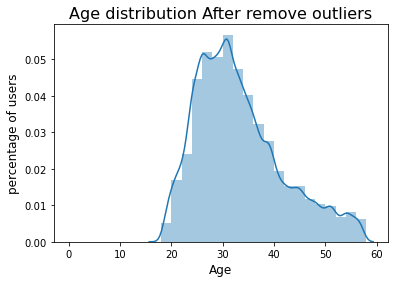

In [86]:
df['age'] = 2019 - df.member_birth_year
df_1 = df.copy()
df_1 = Interquartile(df_1,'age')

bins = np.arange(0,df_1.age.max()+2,2)
sns.distplot(df_1.age,bins=bins)
plt.title('Age distribution After remove outliers',fontsize=16)
plt.xlabel('Age',fontsize=12)
plt.ylabel('percentage of users',fontsize=12);

## most of users' ages at their thirties.

## **How far do they go?**

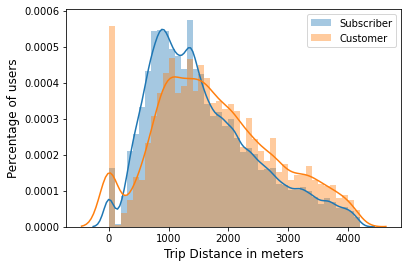

In [90]:
df_2 = df_1.copy()
df_2 = Interquartile(df_2,'distance_meter')

distance_meter_subscriber = df_2.query('user_type == "Subscriber"').distance_meter
distance_meter_customer   = df_2.query('user_type == "Customer"').distance_meter

bins = np.arange(0,distance_meter_subscriber.max()+100,100) 
sns.distplot(distance_meter_subscriber,bins=bins,label='Subscriber')
sns.distplot(distance_meter_customer,bins=bins,label='Customer')
plt.xlabel('Trip Distance in meters',fontsize=12)
plt.ylabel('Percentage of users',fontsize=12)
plt.legend();

## most of users cycle around 1 km for both costumer and subscriber.

## **How long does the average trip take?**

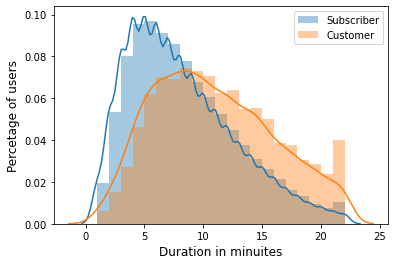

In [91]:
df_3 = df_2.copy()
df_3 = Interquartile(df_3,'duration_min')

#subscriber or customer
duration_min_subscriber = df_3.query('user_type == "Subscriber"').duration_min
duration_min_customer = df_3.query('user_type == "Customer"').duration_min

bins = np.arange(0,duration_min_subscriber.max()+1,1) 
sns.distplot(duration_min_subscriber,bins=bins,label='Subscriber')
sns.distplot(duration_min_customer,bins=bins,label='Customer')
plt.xlabel('Duration in minuites',fontsize=12)
plt.ylabel('Percetage of users',fontsize=12)
plt.legend();

## most of costumers' trips take around 15 mins, subscribers' trips take around 10 mins.

## **Which stations are most popular?** 


## Top 20 Start Station

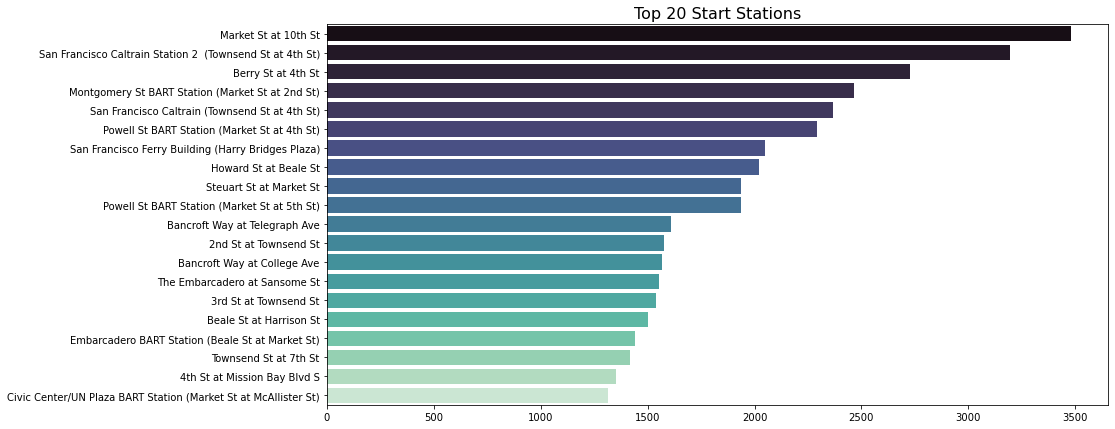

In [101]:
fig =plt.figure(figsize=(14,7))
top_20_start_station = df_3.start_station_name.value_counts().head(20)

sns.barplot(x=top_20_start_station.values,y=top_20_start_station.index,palette='mako')
plt.title('Top 20 Start Stations',fontsize=16);

## Top 20 End Station

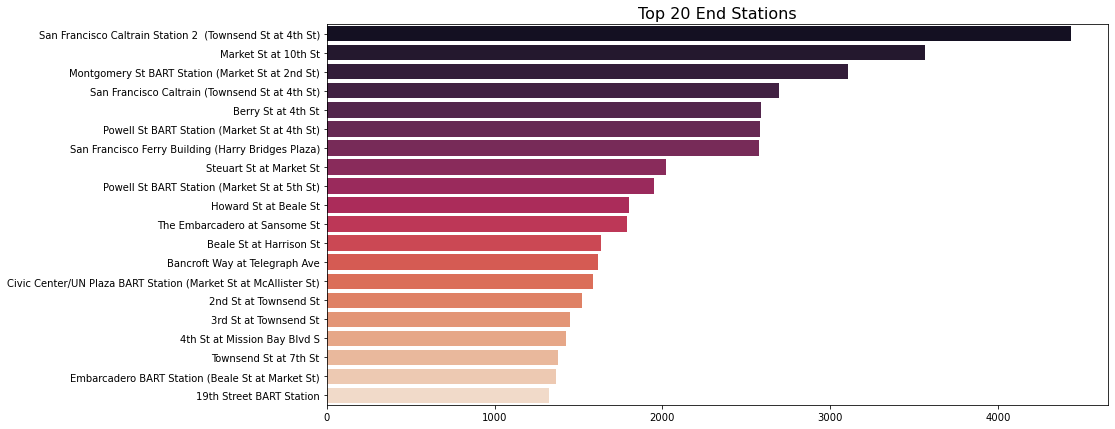

In [102]:
fig =plt.figure(figsize=(14,7))
top_20_end_station = df_3.end_station_name.value_counts().head(20)
sns.barplot(x=top_20_end_station.values,y=top_20_end_station.index,palette='rocket')
plt.title('Top 20 End Stations',fontsize=16);

## **When are most trips taken in terms of time of day?**

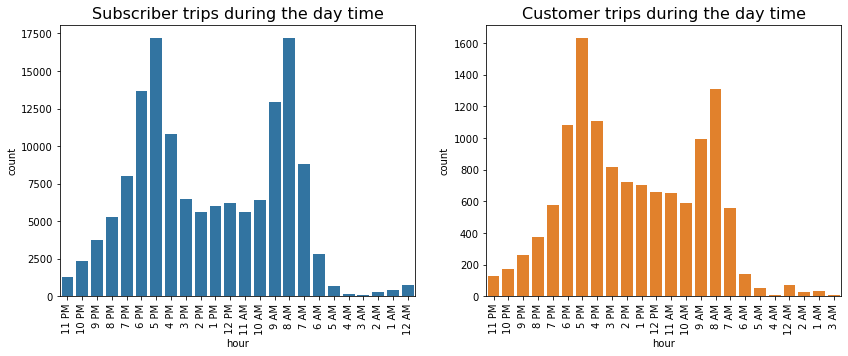

In [104]:
colors= sns.color_palette()[0:2]

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
sns.countplot(x=df_3.query('user_type=="Subscriber"')['hour'],color=colors[0],ax=ax)
plt.title('Subscriber trips during the day time',fontsize=16)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
sns.countplot(x=df_3.query('user_type=="Customer"')['hour'],color=colors[1],ax=ax)
plt.title('Customer trips during the day time',fontsize=16)
plt.xticks(rotation=90);

#fig ,ax = plt.subplots(1,2,figsize=(14,5))
#for i,label in enumerate(df_3.user_type.unique()):
#    sns.countplot(x=df_3.query(f'user_type=="{label}"')['hour'],color=color,ax=ax[i])
#    plt.title(f'{label} trips during the day time',fontsize=16)
#    plt.xticks(rotation=90);

* ## most of trips start between 4-6 PM or 7-9 AM.
* ## trips in day have the same pattern for both costumers and subscribers.

## **What days of the week are most rides taken on?**


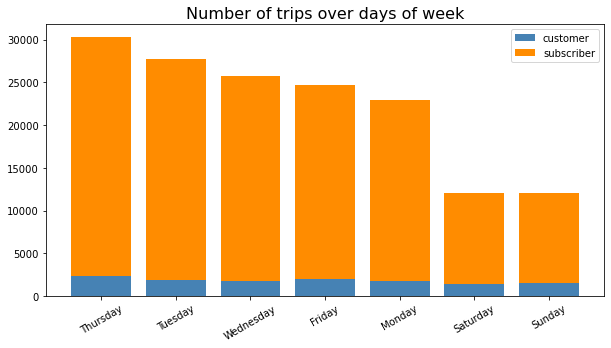

In [107]:
fig = plt.figure(figsize=(10,5))

day_subscriber = df_3.query('user_type=="Subscriber"')['day'].value_counts().reset_index()
day_subscriber.rename(columns={'day':'subscriber'},inplace=True)

day_customer = df_3.query('user_type=="Customer"')['day'].value_counts().reset_index()
day_customer.rename(columns={'day':'customer'},inplace=True)

users = pd.merge(day_subscriber,day_customer,how='inner',on='index')

plt.bar(users['index'],users.customer,color='steelblue',label='customer')
plt.bar(users['index'],users.subscriber,color='darkorange',label='subscriber',bottom=users.customer)
plt.title('Number of trips over days of week',fontsize=16)
plt.xticks(rotation=30)
plt.legend();

## numbers of costumers trips over a week is steady unlike subscribers trips which decreased significantlly during weekends.

## **Do Subscriber trips take more time than Customer?**

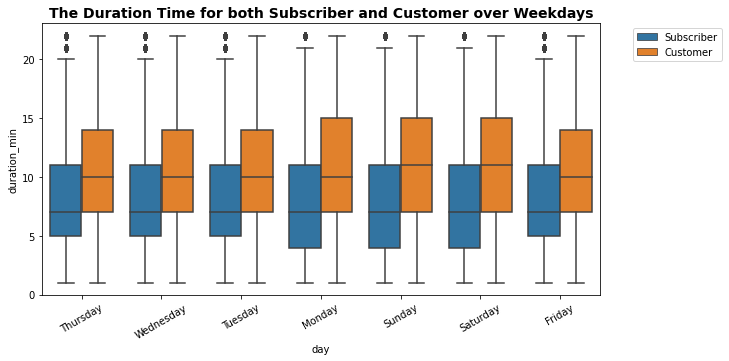

In [45]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(data=df_3,x='day',y='duration_min',hue='user_type')
plt.title('The Duration Time for both Subscriber and Customer over Weekdays',fontsize=14,fontweight='bold')
plt.xticks(rotation=30)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left');

## usually costumers trips take more time than subscriber.

## Conclusion
* most of users' ages at their thirties.
* most of users cycle around 1 km for both costumer and subscriber.
* most of costumers' trips take around 15 mins, subscribers' trips take around 10 mins.
* most of trips start between 4-6 PM or 7-9 AM.
* trips in day have the same pattern for both costumers and subscribers.
* numbers of costumers trips over a week is steady unlike subscribers trips which decreased significantlly during weekends.
* usually costumers trips take more time than subscriber.